#Forward Modeling
This notebook makes a toy model similar to my experiment, to check that I know what I am doing and that I get the right answer.

## Status as of Thursday Evening:
  - The ForwardModeler class seems to work as expected, and I can reproduce Malmquist bias.
  - TODO: Add information about detection rate as a function of mass-ratio, and randomly decide if I detect a given binary system using the detection rate.

In [237]:
import numpy as np
import pandas as pd
import HelperFunctions
import os
import scipy.stats
import matplotlib.pyplot as plt
import IMF_utils
from astropy import units as u, constants
from scipy.optimize import newton
import pandas as pd
from Mamajek_Table import MamajekTable

%matplotlib inline
reload(HelperFunctions)

<module 'HelperFunctions' from '/Users/kgulliks/.PythonModules/GeneralScripts/HelperFunctions.py'>

In [265]:
def truncated_expon(scale=0.0, Nsamp=100):
    """ Get random samples from an exponential distribution confined to [0,1]
    """
    u = np.random.uniform(size=Nsamp)
    x = u**(1./(1-gamma))
    return x

def get_eccentric_anomaly(M, e):
    """
    Get the eccentric anomaly (E) from the mean anomaly (M) and orbital eccentricity (e)
    Uses the equation M = E - esinE
    """
    if HelperFunctions.IsListlike(M):
        return np.array([get_eccentric_anomaly(Mi, e) for Mi in M])

    func = lambda E: E - e*np.sin(E) - M
    dfunc = lambda E: 1.0 - e*np.cos(E)
    d2func = lambda E: e*np.sin(E)
    
    output = newton(func, np.pi, fprime=dfunc, fprime2=d2func)

    #output = minimize_scalar(chisquare, bounds=[0, 2*np.pi], method='brent')
    return output


def get_true_anomaly(E, e):
    """
    Get the true anomaly from the eccentric anomaly (E) and the eccentricity
    """
    A = (np.cos(E) - e)/(1-e*np.cos(E))
    B = (np.sqrt(1.-e**2) * np.sin(E)) / (1.-e*np.cos(E))
    return np.arctan2(B, A)


def get_rv(phase, e, K1, w):
    """
    Get the radial velocity at the given phase, given the parameters:
    e = eccentricity
    K1 = semiamplitude
    w = longitude of pericenter (radians)
    """
    M = 2.0*np.pi*phase
    Erad = get_eccentric_anomaly(M, e)
    nu = get_true_anomaly(Erad, e)

    return K1 * (np.cos(nu+w) + e*np.cos(w))



class ForwardModeler(object):
    """
    A class to do forward modeling to measure population parameters amongst observational biases
    """
    
    def __init__(self, *args, **kwargs):
        """ Eventually, this should take all the data I have in some reasonable way
        """
        MT = MamajekTable()
        self.mass2Vmag = MT.get_interpolator('Msun', 'Mv')
        # Log-normal parameters for the parallax. 
        #These come from fitting the Hipparchos data and give a good 'chi-by-eye' fit.
        self.plx_shape, self.plx_scale, self.plx_loc = (0.86414506569840466, 5.2836463711499855, -0.36291878650952103)
    
    def IMF(self, low_mass, high_mass, size=1):
        """
        Draw 'size' samples from the IMF between low_mass and high_mass
        """
        masses = IMF_utils.inverse_imf(np.random.uniform(size=size), mmin=low_mass, mmax=high_mass)
        return masses
        
    
    def model(self, pars, N_obs=None, Vmag_lim=None, N_total=10000, *args, **kwargs):
        """
        Generate samples from the primary star distributions given in pars.
        
        Parameters
        ==========
         - pars: An iterable containing the parameters for the parent population
         - N_obs: The number of observations to pull from the parent population (volume-limited sample).
                  Either this or Vmag_lim **MUST** be given.
         - Vmag_lim: The V-magnitude limiting magnitude to include in the sample. Either this or N_obs
                     **MUST** be given.
         - N_total: The number of samples to draw representing the parent population. This gives a 
                    tradeoff between accuracy and speed.
         
        Returns:
        =========
        A pandas DataFrame containing lots of information about the synthetic binary stars.
        """
        # First, make sure we were given one of N_obs or Vmag_lim
        if N_obs is None and Vmag_lim is None:
            raise InputError('You must give at least one of N_obs or Vmag_lim!')
        print(N_obs, Vmag_lim)
        
        # physical parameters
        mult_rate = pars[0]  # Overall multiplicity rate
        mrd_gamma = pars[1]  # Mass-ratio distribution power law factor
        sep_mu, sep_sigma = pars[2:4]  # Separation distribution parameters (assumed log-normal)
        ecc_alpha = pars[4]  # Eccentricity distribution power law factor
        
        # Observational parameters
        Mlow, Mhigh = pars[5:7]  # Lowest and highest masses in the sample
        
        # Make a parent distribution with the correct multiplicity rate
        targets = np.random.uniform(size=N_total)
        population = pd.DataFrame(data=dict(binary=(targets < mult_rate)))
        population['q'] = np.nan
        population['e'] = np.nan
        population['a'] = np.nan
        population['vel'] = np.nan
        binary_idx = population.index[population.binary]
        
        # Take random samples from the parent population
        population['M1'] = self.IMF(Mlow, Mhigh, size=N_total)
        N_binary = sum(population.binary)
        population.ix[binary_idx, 'q'] = truncated_expon(scale=mrd_gamma, Nsamp=N_binary)
        population.ix[binary_idx, 'e'] = truncated_expon(scale=ecc_alpha, Nsamp=N_binary)
        population.ix[binary_idx, 'a'] = np.exp(np.random.normal(loc=sep_mu, scale=sep_sigma, size=N_binary))
        
        # Calculate the velocity of each of the binary observations
        phase = np.random.uniform(size=N_binary)
        omega = 2*np.pi*np.random.uniform(size=N_binary)
        sini = np.random.uniform(size=N_binary)
        M1 = population.ix[binary_idx, 'M1'].values * u.M_sun
        a = population.ix[binary_idx, 'a'].values * u.AU
        e = population.ix[binary_idx, 'e'].values
        q = population.ix[binary_idx, 'q'].values
        K1 = sini * np.sqrt((constants.G * M1 / ((1+q)*a*(1-e**2))).decompose()).to(u.km/u.s).value
        #K1 = K1.to(u.km/u.s).value
        population.ix[binary_idx, 'vel'] = np.array([get_rv(phi, ecc, K, w) for phi, ecc, K, w in zip(phase, e, K1, omega)])
        
        
        # Choose random distances for the population stars using the Hipparchos parallaxes for a distribution.
        # This ASSUMES that there is no dependence of spectral type vs. separation (there shouldn't be, right?)
        plx = scipy.stats.lognorm.rvs(loc=self.plx_loc, s=self.plx_shape, scale=self.plx_scale, size=N_total)
        population['distance'] = 1000. / plx
        
        # Get the angular separation for the binaries
        # TODO: Use the phase/orbit information to do this right!
        f = 1.0 # Edit this with the inclination and such later
        population['ang_sep'] = f * population['a'] / population['distance']
        
        # Put the primary star magnitudes into the population dataframe.
        #If the angular separation is < 1", combine the magnitude from the primary and secondary stars.
        prim_mag = self.mass2Vmag(population.M1)
        sec_mag = self.mass2Vmag(population.M1 * population.q)
        population['Vmag'] = prim_mag + 5*np.log10(population.distance) - 5.0
        condition = (population.binary) & (population.ang_sep < 1.0)
        population.loc[condition, 'Vmag'] = HelperFunctions.add_magnitudes(prim_mag[condition.values], sec_mag[condition.values])
        
        # Draw the sample from the population in the appropriate way
        if Vmag_lim is not None:
            sample = population.loc[population.Vmag < Vmag_lim].copy()
            if N_obs is not None:
                sample = sample.sample(n=N_obs).reset_index()
        else:
            sample = population.sample(n=N_obs).reset_index()
        
        return sample

In [270]:
pars = [0.5, 0.4, np.log(200), np.log(10), 0.7, 2., 6.]
fw = ForwardModeler()
vl_sample = fw.model(pars, N_obs=1000)
ml_sample = fw.model(pars, N_obs=1000, Vmag_lim=6.0)


(1000, None)
(1000, 6.0)


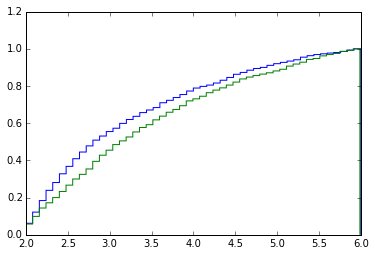

In [271]:
_ = plt.hist(vl_sample.M1.values, bins=50, cumulative=True, normed=True, histtype='step')
_ = plt.hist(ml_sample.M1.values, bins=50, cumulative=True, normed=True, histtype='step')

In [245]:
plt.hist?

In [45]:
masses = IMF_utils.inverse_imf(np.random.uniform(size=10000), mmin=2, mmax=10)

(array([ 1695.,  1333.,  1030.,   849.,   649.,   564.,   459.,   410.,
          358.,   316.,   259.,   253.,   199.,   168.,   144.,   154.,
          161.,   106.,   109.,   101.,   104.,    70.,    85.,    77.,
           63.,    70.,    57.,    45.,    65.,    47.]),
 array([ 2.        ,  2.26649478,  2.53298956,  2.79948433,  3.06597911,
         3.33247389,  3.59896867,  3.86546344,  4.13195822,  4.398453  ,
         4.66494778,  4.93144256,  5.19793733,  5.46443211,  5.73092689,
         5.99742167,  6.26391644,  6.53041122,  6.796906  ,  7.06340078,
         7.32989556,  7.59639033,  7.86288511,  8.12937989,  8.39587467,
         8.66236944,  8.92886422,  9.195359  ,  9.46185378,  9.72834856,
         9.99484333]),
 <a list of 30 Patch objects>)

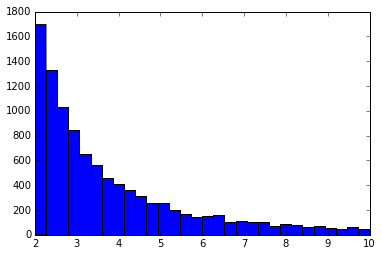

In [47]:
plt.hist(masses, bins=30)